20180524

Adding a censor label for calculation of the C-index and for future train improvements

Adding sample_type_id which must be 01A for the primary tumor

20180525

Fixed the Data Loader so that we sort on filename before calling.  Then our indices work and our loading of the file works also. 

20180530

Using new sampler from tumor_classifier where images are a fixed size.  In tumor_classifier we can get 99% accuracy with tumor/normal classes

Turn into classifier of > 1000 days (~ 3 years)




In [1]:
%pylab inline
import pandas as pd
import numpy as np
import fastai
import torch
from pathlib import Path
import PIL
import tqdm
import os
import json
tqdm.monitor_interval = 0

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.conv_learner import resnet34, resnet152, transforms_top_down, CropType, \
    tfms_from_model, ConvLearner, optim, T
from fastai.dataset import ImageClassifierData, Denormalize
from fastai.metrics import accuracy, f1
from fastai.sgdr import TrainingPhase, DecayType
from lifelines.utils import concordance_index

In [ ]:
def cindex_metric(preds, targs):
    try:
        cindex = concordance_index(preds, targs)
    except:
        cindex = 0.0
    return cindex

In [3]:
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(1)
torch.cuda.current_device()


1

In [4]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp_class_1"
EXP_MODEL_PATH = EXP_PATH/"models"
EXP_DATA = EXP_PATH/"data"
EXP_TRAIN_DATA = EXP_DATA/"train"
EXP_TEST_DATA = EXP_DATA/"test"
PATIENT_JSON = EXP_PATH/'patient_split.json'
TRAIN_CSV = EXP_PATH/'level_1_train.csv'
TRAIN_CSV_FULL = EXP_PATH/'level_1_train_full.csv'
TEST_CSV = EXP_PATH/'level_1_test.csv'
TEST_CSV_FULL = EXP_PATH/'level_1_test_FULL.csv'

for d in [EXP_PATH, EXP_DATA, EXP_TRAIN_DATA, EXP_TEST_DATA, EXP_MODEL_PATH]:
    if not d.exists():
        d.mkdir()

In [5]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
def get_tissue_type(x):
    return x.split('-')[4]
def get_sample_type(x):
    ''' 01A samples are "primary tumor" and we want just those samples'''
    return x.split('-')[3]

tissue_type = slides.slide_file_name.apply(get_tissue_type)
sample_type = slides.slide_file_name.apply(get_sample_type)
slides = slides.loc[(tissue_type == '01') &  (sample_type=='01A'),:].copy()

In [6]:
try:
    with open(PATIENT_JSON, 'r') as fobj:
        patients = json.load(fobj)
        train_patients = patients['train']
        val_patients = patients['val']
        test_patients = patients['test']
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]

    train_csv_df = pd.read_csv(TRAIN_CSV_FULL)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
except:
    slides['days_proxy'] = \
        slides.days_to_death.fillna(slides.days_to_last_follow_up).apply(lambda x : 1.0 if x>1000 else 0.0)
    slides = slides.loc[slides.days_proxy.notnull()].copy()
    #create censor label
#    slides['event_observed'] = True
#    slides.loc[slides.days_to_last_follow_up.notnull(),'event_observed'] = False    

    patients = random.permutation(list(set(slides.submitter_id)))
    
    split     = int(0.7 * len(patients))
    val_split = int(0.7 * split)
    train_patients = patients[:split]
    val_patients   = patients[val_split:split]
    test_patients  = patients[split:]

    patient_split = {
        'train': list(train_patients),
        'val': list(val_patients),
        'test': list(test_patients)
    }
    with open(EXP_PATH/'patient_split.json', 'w') as fobj:
        json.dump(patient_split, fobj)

    print(len(train_patients), len(val_patients), len(test_patients))
    
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides  = slides.loc[slides.submitter_id.isin(test_patients)]
    
    
    train_items = []
    test_items = []
    num_slides = []
    slide_level = 'level_1'
    samples_per_slide = 5
    
    
    for ix, patient in tqdm.tqdm_notebook(slides.iterrows(), total=len(slides)):
        sfp = LIVER_SAMPLES/patient.slide_file_name.upper()/slide_level
        sample_files = list(sfp.iterdir())
        num_samples = len(sample_files)
        num_slides.append(num_samples)
        for fn in np.random.choice(sample_files, size=min(samples_per_slide,num_samples), replace=False):
            if patient.submitter_id in train_patients:
                dest_path = EXP_TRAIN_DATA
                train = True
                if patient.submitter_id in val_patients:
                    val = True
                else:
                    val = False
            else:
                dest_path = EXP_TEST_DATA
                train = False

            slide_id = os.path.basename(patient.slide_file_name).split('.')[0]
            img_id = os.path.basename(fn).split('.')[0]
            new_fn_base = '-'.join([slide_id, img_id]) + '.tiff'
            full_path = dest_path/new_fn_base

            if not full_path.exists():
                os.symlink(fn, dest_path/new_fn_base)

            if train:
                train_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'val_patient': val,
                    'patient_id': patient.submitter_id,
                    'slide_file':patient.slide_file_name
                })
            else:
                test_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'patient_id': patient.submitter_id,
                    'slide_file':patient.slide_file_name
                })
       
    
    train_csv_df = pd.DataFrame(list(random.permutation(train_items)))
     #fast.ai will sort on filenames, idx will be a mess!
    train_csv_df = train_csv_df.sort_values('fn').reset_index(drop=True)
    
    train_csv_df[['fn','val']].to_csv(TRAIN_CSV, index=False)
    train_csv_df.to_csv(TRAIN_CSV_FULL, index=False)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
    
    test_csv_df = pd.DataFrame(test_items)
    test_csv_df = test_csv_df.sort_values('fn').reset_index(drop=True)
    
    test_csv_df[['fn','val']].to_csv(TEST_CSV, index=False)
    test_csv_df.to_csv(TEST_CSV_FULL, index=False)
    

In [24]:
f_model = resnet34
sz=256
bs=18
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, crop_type=CropType.CENTER)
md = ImageClassifierData.from_csv(
    EXP_PATH, "data/train", TRAIN_CSV, tfms=tfms, bs=bs, val_idxs=val_idx.values, continuous=False
)


In [9]:
#learn = ConvLearner.pretrained(f_model, md,custom_head=head_relu)
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

### criteria must be from funtional library.
#import torch.nn.functional as F
#learn.crit = F.mse_loss

In [10]:
learn.children[-10:]

[AdaptiveConcatPool2d(
   (ap): AdaptiveAvgPool2d(output_size=(1, 1))
   (mp): AdaptiveMaxPool2d(output_size=(1, 1))
 ), Flatten(
 ), BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True), Dropout(p=0.25), Linear(in_features=1024, out_features=512), ReLU(), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True), Dropout(p=0.5), Linear(in_features=512, out_features=2), LogSoftmax()]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 45/52 [00:02<00:00, 16.68it/s, loss=7.44] 


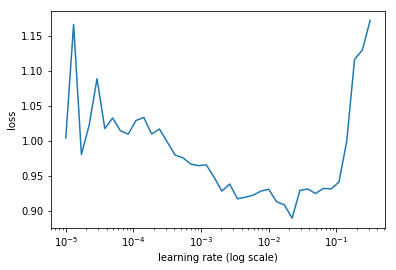

In [11]:
# set to true to try learning rate finder
if True:
    learn.save('tmp')
    lrf=learn.lr_find()
    learn.sched.plot(0)
    learn.load('tmp')

In [12]:
lr = 10e-3
print(lr)

0.01


In [13]:
#lr = 0.003
learn.fit(lr, 10, cycle_len=5, use_clr=(32,5), best_save_name='liver_class_best_1', metrics=[accuracy])
learn.save('liver_class_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.789227   1.019214   0.579221  
    1      0.672686   1.028405   0.607792                  
    2      0.594179   0.969547   0.618182                  
    3      0.533808   0.896067   0.615584                  
    4      0.503998   0.92978    0.615584                  
    5      0.496741   1.038514   0.620779                  
    6      0.540999   1.089875   0.61039                   
    7      0.521949   0.993727   0.597403                  
    8      0.523055   0.949501   0.620779                  
    9      0.479561   0.944782   0.618182                  
    10     0.49394    0.943129   0.612987                  
    11     0.551962   1.060471   0.633766                  
    12     0.540045   1.097426   0.612987                  
    13     0.533137   1.000894   0.631169                  
    14     0.48004    0.95134    0.625974                  
    15     0.462625   1.181825   0.620779               

In [15]:
learn.load('liver_class_best_1')
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2) #unfreeze res and head layers
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_class_best_2', metrics=[accuracy])
learn.save('liver_class_2')

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.60776    29.52373   0.607792  
    1      0.595494   0.871252   0.638961                  
    2      0.548118   1.389527   0.633766                  
    3      0.529724   0.90415    0.607792                  
    4      0.515588   1.553944   0.644156                  
    5      0.502664   69.969027  0.566234                  
    6      0.500824   2.14796    0.633766                  
    7      0.512226   1.386228   0.631169                  
    8      0.499389   0.96274    0.625974                  
    9      0.473418   0.935953   0.620779                  
    10     0.497038   1.186098   0.612987                  
    11     0.521908   0.882961   0.633766                  
    12     0.505727   1.118172   0.623377                  
    13     0.502184   0.893606   0.633766                  
    14     0.496486   2.101323   0.625974                  
    15     0.4609     2.502177   0.651948               

In [20]:
learn.load('liver_class_best_2')
lrs = np.array([lr/100, lr/10, lr])
learn.unfreeze() #unfreeze all types, including conv layers
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_class_best_3', metrics=[accuracy])
learn.save('liver_class_3')

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.466903   207.615027 0.618182  
    1      0.512074   0.784765   0.644156                  
    2      0.523039   6.214885   0.612987                  
    3      0.496142   0.906365   0.618182                  
    4      0.467414   1.593034   0.641558                  
    5      0.479762   0.925802   0.638961                  
    6      0.451653   2.623297   0.61039                   
    7      0.429963   6.472501   0.654545                  
    8      0.412352   5.080597   0.636364                  
    9      0.399696   4.008613   0.646753                  
    10     0.416781   14.163379  0.641558                  
    11     0.44881    7.329286   0.628571                  
    12     0.438781   3.112176   0.618182                  
    13     0.416192   2.101975   0.636364                  
    14     0.40666    1.072613   0.612987                  
    15     0.36924    3.900143   0.638961               

In [21]:
learn.load('liver_class_best_3')

In [25]:
train_csv_df.he

,fn,patient_id,slide_file,val,val_patient
0,TCGA-2V-A95S-01A-01-TS1-153.tiff,TCGA-2V-A95S,TCGA-2V-A95S-01A-01-TS1.88A3BD39-B510-464C-861...,0.0,False
1,TCGA-2V-A95S-01A-01-TS1-266.tiff,TCGA-2V-A95S,TCGA-2V-A95S-01A-01-TS1.88A3BD39-B510-464C-861...,0.0,False
2,TCGA-2V-A95S-01A-01-TS1-355.tiff,TCGA-2V-A95S,TCGA-2V-A95S-01A-01-TS1.88A3BD39-B510-464C-861...,0.0,False
3,TCGA-2V-A95S-01A-01-TS1-413.tiff,TCGA-2V-A95S,TCGA-2V-A95S-01A-01-TS1.88A3BD39-B510-464C-861...,0.0,False
4,TCGA-2V-A95S-01A-01-TS1-499.tiff,TCGA-2V-A95S,TCGA-2V-A95S-01A-01-TS1.88A3BD39-B510-464C-861...,0.0,False


In [22]:
multi_test_preds, test_y = learn.TTA(is_test=True)
test_preds = np.mean(multi_test_preds, 0)


TypeError: 'NoneType' object is not iterable

In [ ]:
preds.shape, accuracy(T(preds), T(y)), f1_score(y, np.argmax(preds, 1))

In [ ]:
test_preds.shape, accuracy(T(test_preds), T(test_y)), f1_score(test_y, np.argmax(test_preds, 1))

In [ ]:
y_pred,y_targ = learn.predict_with_targs()

In [ ]:
print(cindex_metric(y_pred,y_targ))

In [ ]:
print(y_pred.shape)
print(md.val_dl.dataset.n)
print(md.trn_dl.dataset.n)


In [ ]:
y_pred_val = learn.predict_dl(md.trn_dl)
val_df = train_csv_df.loc[~train_csv_df.val_patient,:].copy()

In [ ]:
md.val_ds.fnames[:10]

In [ ]:
val_df.head()

In [ ]:
val_df.loc[:,'y_pred']=y_pred_val.copy()

In [ ]:
plt.scatter(np.clip(val_df.y_pred,0,np.inf),val_df.val)

In [ ]:
print(concordance_index(val_df.y_pred,val_df.val))
print(cindex_metric(val_df.y_pred,val_df.val))


### TEST

In [ ]:
y_pred = learn.predict_dl(md_test.val_dl)
test_df = test_csv_df.copy()
test_df['y_pred'] = y_pred

y_pred.shape, test_df.shape

In [ ]:
yp_pred = test_df.groupby('patient_id').y_pred.min()
yp_targ = test_df.groupby('patient_id').val.mean()
concordance_index(yp_pred, yp_targ )

In [ ]:
scatter(yp_targ, yp_pred)

In [ ]:
test_df.val.hist()

In [ ]:
train_csv_df.val.hist()